In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(111)

In [3]:
device = torch.device("cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [5]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

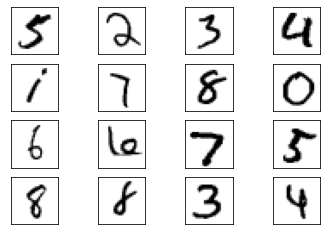

In [7]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [9]:
discriminator = Discriminator().to(device=device)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output
generator = Generator().to(device=device)

In [11]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [12]:
train_plot=[]
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            #gendict[epoch]=generator          
            generated_samples_plot = generated_samples.cpu().detach()
            train_plot.append([epoch, generated_samples_plot])

Epoch: 0 Loss D.: 0.5412760972976685
Epoch: 0 Loss G.: 0.5153388381004333
Epoch: 1 Loss D.: 0.04715801402926445
Epoch: 1 Loss G.: 6.1392436027526855
Epoch: 2 Loss D.: 0.03100760467350483
Epoch: 2 Loss G.: 3.846494674682617
Epoch: 3 Loss D.: 0.004632871598005295
Epoch: 3 Loss G.: 5.032060146331787
Epoch: 4 Loss D.: 0.01590071991086006
Epoch: 4 Loss G.: 4.969620227813721
Epoch: 5 Loss D.: 0.052896175533533096
Epoch: 5 Loss G.: 5.569124221801758
Epoch: 6 Loss D.: 0.03173278644680977
Epoch: 6 Loss G.: 4.529135227203369
Epoch: 7 Loss D.: 0.0761520266532898
Epoch: 7 Loss G.: 3.055007219314575
Epoch: 8 Loss D.: 0.1207982525229454
Epoch: 8 Loss G.: 2.8473198413848877
Epoch: 9 Loss D.: 0.16616320610046387
Epoch: 9 Loss G.: 3.1525392532348633
Epoch: 10 Loss D.: 0.12946158647537231
Epoch: 10 Loss G.: 3.176778554916382
Epoch: 11 Loss D.: 0.2064095437526703
Epoch: 11 Loss G.: 2.3618128299713135
Epoch: 12 Loss D.: 0.3043888509273529
Epoch: 12 Loss G.: 2.473623037338257
Epoch: 13 Loss D.: 0.166892662

#latent_space_samples = torch.randn(batch_size, 100).to(device=device)
#generated_samples = generator(latent_space_samples)
#generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(train_plot[25][1][i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [28]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

Figure = plt.figure()
 
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(train_plot[0][1][i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    
plt.suptitle("Epoch - 0")

# function takes frame as an input
def AnimationFunction(frame):
 
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(train_plot[frame][1][i].reshape(28, 28), cmap="gray_r")
        plt.xticks([])
        plt.yticks([])
    # displaying the title
    plt.suptitle("Epoch - " + str(frame))
    # line is set with new values of x and y
    #line_plotted.set_data((x, y))

anim_created = FuncAnimation(Figure, AnimationFunction, frames=50, interval=200)

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)
 
# good practice to close the plt object.
plt.close()

C:\ProgramData\Anaconda3\envs\gan\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
